### Regression notebook for Wadhwani AI competition

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import timm
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2,torchvision
from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
from timm.optim.optim_factory import create_optimizer_v2
from timm import utils
from fastprogress.fastprogress import format_time
from fastai.vision.all import *


class CFG:
    seed = 46
    n_splits = 5
    SZ = 1024
    debug = False
    BS = 20
    EP = 10
    MODEL = 'tf_efficientnet_b0_ns'
    LR = 5e-03
    WD = 1e-08

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

In [3]:
set_seed(CFG.seed)

In [4]:
DIR = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
IMG_PATH = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'
submit = pd.read_csv(os.path.join(DIR,'SampleSubmission.csv'))
train = pd.read_csv(os.path.join(DIR,'Train.csv'))
test_df = pd.read_csv(os.path.join(DIR,'Test.csv'))

VERSION = "NB_EXP_V0_007_Regression"
MODEL_FOLDER = Path(f"///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/runs/Regression/{VERSION}/")
os.makedirs(MODEL_FOLDER,exist_ok=True)
KERNEL_TYPE = f"{CFG.MODEL}_{CFG.SZ}_bs{CFG.BS}_ep{CFG.EP}_lr{str(CFG.LR).replace('-','')}_wd{str(CFG.WD).replace('-','')}"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/runs/Regression/NB_EXP_V0_007_Regression
tf_efficientnet_b0_ns_1024_bs20_ep10_lr0.005_wd1e08


In [5]:
def make_train_dataset():
    train_new_pbw = pd.DataFrame()
    train_new_pbw['image_id_worm']= train['image_id_worm'].unique()
    train_new_pbw = pd.merge(train_new_pbw,train[train['worm_type']=='pbw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_pbw['worm_type'] = 'pbw'
    train_new_pbw.fillna(0,inplace=True)
    
    train_new_abw = pd.DataFrame()
    train_new_abw['image_id_worm']= train['image_id_worm'].unique()
    train_new_abw = pd.merge(train_new_abw,train[train['worm_type']=='abw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_abw['worm_type'] = 'abw'
    train_new_abw.fillna(0,inplace=True)
    
    train_out = pd.concat([train_new_pbw,train_new_abw],0).reset_index(drop=True)
    
    assert len(train_out) == train['image_id_worm'].nunique()*2
    train_out = pd.pivot(train_out,'image_id_worm','worm_type','number_of_worms').reset_index()
    train_out[['abw','pbw']] = train_out[['abw','pbw']].astype(int)
    
    labels = [f'{i}' for i in range(10)]
    train_out['abw_bins'] = pd.cut(train_out['abw'],10,labels=labels)
    train_out['pbw_bins'] = pd.cut(train_out['pbw'],10,labels=labels)
    train_out['consol_bins'] = train_out['abw_bins'].astype(str)+'_'+train_out['pbw_bins'].astype(str)
    
#     train_out = train_out[['image_id_worm','abw','pbw','abw_bins','pbw_bins','consol_bins']]
    return train_out

train_new = make_train_dataset()

In [6]:
train_new.head(1)

worm_type,image_id_worm,abw,pbw,abw_bins,pbw_bins,consol_bins
0,id_0002ea6f15c7fa6f4c221783.jpg,0,51,0,0,0_0


### Get kfolds

In [7]:
train_files = []
val_files = []
fold = []

for folds in [0,1,2,3,4]:
    files = list(pd.read_csv(f'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/splits/fold{folds}.txt',header=None)[0].apply(lambda x:x.split("/")[-1]))
    fold.append([folds]*len(files))
    train_files.append(files)

train_files= ([item for sublist in train_files for item in sublist])
fold= ([item for sublist in fold for item in sublist])
fold_dict = dict(zip(train_files,fold))
train_new['fold'] = train_new['image_id_worm'].map(fold_dict)

In [8]:
train_new = train_new[~train_new['fold'].isna()].reset_index(drop=True)
train_new['fold'] = train_new['fold'].astype(int)
print(train_new['fold'].unique())

[1 0 2 4 3]


#### Data loader

In [9]:
class WadhwaniDataset(Dataset):
    def __init__(self,
                 df=train_new,
                 mode='train',
                augs = None):
        
        self.augs = augs
        self.df = df
        self.mode  = mode
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        image_id = self.df.loc[ix,'image_id_worm']
        img_path = f'{IMG_PATH}/{image_id}'
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.augs is not None:
            img = self.augs(image=img)['image']
    
        if self.mode == 'test':
            return img
        
        label = torch.tensor(self.df[['abw','pbw']].loc[ix]).float()
#         label_pbw = torch.tensor(self.df['pbw'].loc[ix]).long()
        return img, label,image_id

In [10]:
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.
    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

### Augmentations

In [11]:

TRAIN_AUG = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=45, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1,p=0.75),
    A.Blur(p=0.5),
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

### Visualization

<AxesSubplot: >

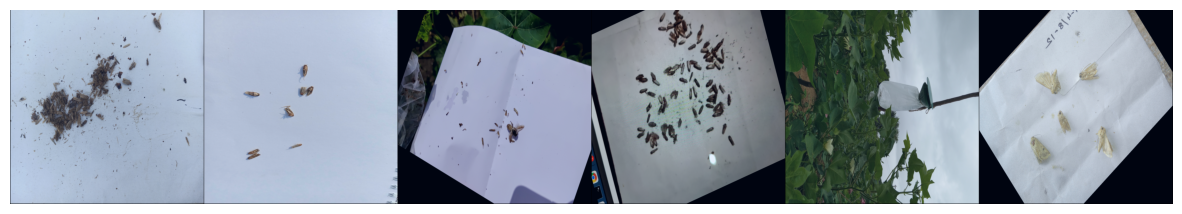

In [12]:
dataset_show = WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target,_ = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8))#, title=[labels_class_map_rev[x] for x in target.numpy()]);

### Model

In [13]:
def get_wadhwani_regression_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, 2),nn.ReLU())
    return model

In [14]:
dl = DataLoader(WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train'),
                          batch_size=2,
                          shuffle=True,
                          num_workers=8,
                          drop_last=True,
                        worker_init_fn=worker_init_fn)

a,b,_ = next(iter(dl))
a.shape,b[0].shape,b[1].shape

(torch.Size([2, 3, 1024, 1024]), torch.Size([2]), torch.Size([2]))

In [15]:
m = get_wadhwani_regression_model(CFG.MODEL)
out = m(a)
print(out, out.shape)

tensor([[0.0829, 0.0000],
        [0.5519, 0.4182]], grad_fn=<ReluBackward0>) torch.Size([2, 2])


In [16]:
nn.L1Loss()(out,b).item()

6.304163932800293

### Train & Validation Function

In [17]:
def train_one_epoch(
    model: nn.Module,
    loader: Iterable,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    mixup_fn: Callable = None,
    grad_scaler: torch.cuda.amp.GradScaler = None,
    mbar: master_bar = None,
):

    model.train()

    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input)
            loss = loss_fn(output, target)
            
        losses_m.update(loss.item(), input.size(0))

        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(batch_idx + 1)
        pbar.comment = f"{losses_m.avg:.4f}"

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg)])


@torch.inference_mode()
def validate(model: nn.Module, loader: Iterable, loss_fn: Callable, mbar: master_bar):
    model.eval()

    l1_loss_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        
        input, target = input.cuda(), target.cuda()
        output = torch.round(model(input))

        loss = loss_fn(output, target).item()
        losses_m.update(loss, input.size(0))

        l1_loss = nn.L1Loss()(output, target).item()
        l1_loss_m.update(l1_loss, output.size(0))

        pbar.update(batch_idx + 1)

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg), ("l1_loss", l1_loss_m.avg)])


### Inference

In [18]:
for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()

In [19]:
test_df.head(1)

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg


In [23]:
out = []
img = []

for fold in range(CFG.n_splits):
    dataset_valid = WadhwaniDataset(train_new.query("fold==@fold").reset_index(drop=True), augs=VALID_AUG, mode="valid")

    print(f"VALID: {len(dataset_valid)}")

    loader_valid = torch.utils.data.DataLoader(dataset_valid, 16, num_workers=8, shuffle=False)

    for input,label,id in tqdm(loader_valid, dynamic_ncols=True, desc="OOF"):
        with torch.cuda.amp.autocast(), torch.no_grad():
            input = input.cuda()
            model = get_wadhwani_regression_model(CFG.MODEL, pretrained=False)
            model.load_state_dict(torch.load(f'{MODEL_FOLDER}/tf_efficientnet_b0_ns_1024_bs20_ep10_lr0.005_wd1e08_CV_{fold}.pth'))
            model.eval()
            model.cuda()
            out.append((model(input)))
            img.append(id)            
    torch.cuda.empty_cache()

VALID: 1418


OOF:   0%|                                                                                       | 0/89 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9ba21588b0>
Traceback (most recent call last):
  File "/home/rajneesh/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/rajneesh/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/rajneesh/miniconda3/envs/pytorch/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9ba21588b0>
Traceback (most recent call last):
  File "/home/rajneesh/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()    
  File "/home/rajneesh/miniconda3

VALID: 1416


OOF:   0%|                                                                                       | 0/89 [00:00…

VALID: 1411


OOF:   0%|                                                                                       | 0/89 [00:00…

VALID: 1417


OOF:   0%|                                                                                       | 0/89 [00:00…

VALID: 1417


OOF:   0%|                                                                                       | 0/89 [00:00…

In [24]:
OOF_ids = list(sum(img, ()))
OOF_preds = torch.cat(out).cpu().numpy()

In [25]:
out

[tensor([[ 0.0000,  7.0430],
         [ 0.0000, 78.6875],
         [ 0.0000,  0.0000],
         [ 0.0000,  7.2617],
         [ 0.0000,  3.1348],
         [ 0.0000,  0.0922],
         [ 0.0000, 19.5625],
         [ 0.0000, 33.1562],
         [ 0.0000, 78.1875],
         [ 7.8477,  0.0000],
         [ 0.0000, 72.9375],
         [ 0.0000, 37.0938],
         [ 0.0000, 74.8750],
         [ 0.0000,  7.7109],
         [ 7.0078,  0.0000],
         [ 1.4199,  7.7930]], device='cuda:0', dtype=torch.float16),
 tensor([[ 3.3027,  6.2969],
         [ 0.0000,  2.4453],
         [ 0.0000,  0.0000],
         [ 0.0000,  2.6270],
         [ 0.0000, 30.1250],
         [ 0.0000, 12.2500],
         [ 0.0000,  7.7344],
         [ 0.0000, 14.5859],
         [ 0.0000, 12.0156],
         [ 0.0000, 90.6875],
         [ 0.0000, 97.0000],
         [ 3.3301,  0.0000],
         [ 0.0000,  1.3486],
         [ 0.0000,  1.9297],
         [ 0.0000, 19.9844],
         [ 0.0000,  2.2480]], device='cuda:0', dtype=torch.fl

In [26]:
# ========================================
# INFERENCE LOOP
# ========================================
test_ds = WadhwaniDataset(test_df, augs=VALID_AUG, mode="test")
test_dl = torch.utils.data.DataLoader(test_ds, 16, num_workers=8, shuffle=False, pin_memory=True)
print('Test size: {}'.format(len(test_dl.dataset)))
    
test_preds = []
test_ids = []

for input in tqdm(test_dl, dynamic_ncols=True, desc="Predicting"):
    pred = []
    with torch.cuda.amp.autocast(), torch.no_grad():
        input = input.cuda()
        for fold in range(5):
            model = get_wadhwani_regression_model(CFG.MODEL, pretrained=False)
            model.load_state_dict(torch.load(f'{MODEL_FOLDER}/tf_efficientnet_b0_ns_1024_bs20_ep10_lr0.005_wd1e08_CV_{fold}.pth'))
            model.eval()
            model.cuda()
            pred.append(model(input))
            torch.cuda.empty_cache()
            gc.collect()
    pred = torch.mean(torch.stack(pred, -1),-1).data.cpu().numpy()
    test_preds.append(pred)
    
test_preds = (np.concatenate(test_preds, axis=0))

Test size: 2803


Predicting:   0%|                                                                               | 0/176 [00:00…

In [27]:
np.save(f'{MODEL_FOLDER}/test_preds.npy',test_preds)

In [28]:
np.save(f'{MODEL_FOLDER}/oof_ids.npy',OOF_ids)

In [29]:
np.save(f'{MODEL_FOLDER}/oof_preds.npy',OOF_preds)

### Fin 